# Prepare data for the analysis of lysine deserts in selected proteomes

<br />

Cells from par. 3 may be ommited so the authors' predictions of transmembrane helices would be used.

# 1. Import libraries

In [2]:
import os
import gzip
from Bio import SeqIO
from ete3 import NCBITaxa
import csv
from ipywidgets import Text, HBox, Label
from IPython.display import display
import pickle
import pandas as pd
import re
import math
import seaborn as sns
import statistics
import matplotlib.pyplot as plt
import numpy as np

ncbi = NCBITaxa()
%matplotlib inline

# 2. Download data

## 2.1. Define proteomes of interest

We will search for lysine desert regions in the following proteomes:

1. **Bacteria**
    * *M. tuberculosis H37Rv* (virulent)
    * *M. smegmatis*
    * *C. glutamicum*
    * *S. ceolicolor*
    * *L. ferrooxidans*
    * *B. subtilis*
    * *E. coli*
    * \+ all Bacteria taxons with assigned status of UniProt reference proteome


2. **Bacteria phages**
    * *Escherichia* phages
    * *Bacillus* phages
    * *Mycobacterium* phages
    
    
3. **Eukaryota**
     * *S. cerevisiae* 
     * *C. elegans*
     * *D. melanogaster*
     * *M. musculus*
     * *H. sapiens*
     * \+ all Eukaryota taxons with assigned status of UniProt reference proteome
    

## 2.2. Download data

In [14]:
%%bash
mkdir -p data
mkdir -p data/Bacteria_proteomes
mkdir -p data/all_Uniprot_ref_bacteria_proteomes
mkdir -p data/all_Uniprot_ref_eukaryota_proteomes
mkdir -p data/Phages_proteomes
mkdir -p data/Eukaryota_proteomes
mkdir -p data/phages_downloads
mkdir -p results/
mkdir -p results/TMH_predictions/

### Download selected Bacteria and Eukaryota proteomes

We manually searched the UniProt database and chose proteomes with status *reference* for the selected abovementioned organisms.

In [ ]:
%%bash

# Download selected Bacteria proteomes
wget ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Bacteria/UP000001584/UP000001584_83332.fasta.gz -P data/bacteria_proteomes
wget ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Bacteria/UP000000757/UP000000757_246196.fasta.gz -P data/bacteria_proteomes
wget ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Bacteria/UP000000582/UP000000582_196627.fasta.gz -P data/bacteria_proteomes
wget ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Bacteria/UP000001973/UP000001973_100226.fasta.gz -P data/bacteria_proteomes
wget ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Bacteria/UP000007382/UP000007382_1162668.fasta.gz -P data/bacteria_proteomes
wget ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Bacteria/UP000001570/UP000001570_224308.fasta.gz -P data/bacteria_proteomes
wget ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Bacteria/UP000000558/UP000000558_83334.fasta.gz -P data/bacteria_proteomes

# Download selected Eukaryota proteomes
wget ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000002311/UP000002311_559292.fasta.gz -P data/eukaryota_proteomes
wget ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000001940/UP000001940_6239.fasta.gz -P data/eukaryota_proteomes
wget ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000000803/UP000000803_7227.fasta.gz -P data/eukaryota_proteomes
wget ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000000589/UP000000589_10090.fasta.gz -P data/eukaryota_proteomes
wget ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000005640/UP000005640_9606.fasta.gz -P data/eukaryota_proteomes

### Download all reference Eukaryota proteomes

In [11]:
%%bash

wget -r --no-parent --cut-dirs=8 -R index.html -A "*[0-9].fasta.gz" ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/ -P data/all_Uniprot_ref_eukaryota_proteomes
for i in `ls data/all_Uniprot_ref_eukaryota_proteomes/ftp.uniprot.org`; do mv data/all_Uniprot_ref_eukaryota_proteomes/ftp.uniprot.org/$i data/all_Uniprot_ref_eukaryota_proteomes/; done
rm -r data/all_Uniprot_ref_eukaryota_proteomes/ftp.uniprot.org

### Download all reference Bacteria proteomes

In [13]:
%%bash

wget -r --no-parent --cut-dirs=8 -R index.html -A "*[0-9].fasta.gz" ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Bacteria/ -P data/all_Uniprot_ref_bacteria_proteomes
for i in `ls data/all_Uniprot_ref_bacteria_proteomes/ftp.uniprot.org`; do mv data/all_Uniprot_ref_bacteria_proteomes/ftp.uniprot.org/$i data/all_Uniprot_ref_bacteria_proteomes/; done
rm -r data/all_Uniprot_ref_bacteria_proteomes/ftp.uniprot.org

### Prepare summary tables

Prepare Tables `Table_reference_eukaryota_proteomes_summary.tsv` and  `Table_reference_bacteria_proteomes_summary.tsv` summarizing the downloaded proteomes.

#### Indexing

Supplementary tables are indexed by taxon name.

#### Columns description

Supplementary table contains the following information:

| Column  | Description  |
|:--|:--|
| **UniProt proteome ID**  | Proteome ID from the UniProt database|
| **NCBI taxon ID**  | Taxon ID from the NCBI |
| **Total sequences in proteome**  | Number of all sequences in proteome |


In [14]:
for domain in ['bacteria', 'eukaryota']:
    sum_dict = {}
    for proteome in os.listdir('data/all_Uniprot_ref_{}_proteomes'.format(domain)):
        
        if proteome == '.DS_Store': continue
        
        f = gzip.open('data/all_Uniprot_ref_{}_proteomes/{}'.format(domain, proteome), "rt")
        seq_no = 0
        for seq in SeqIO.parse(f, "fasta"):
            seq_no += 1

        uniprot = proteome.split('_')[0]
        taxon = proteome.split('_')[1].split('.')[0]
        taxon_ncbi = ncbi.get_taxid_translator([taxon])[int(taxon)]
        
        sum_dict[taxon_ncbi] = [uniprot, taxon, seq_no]
            
        f.close()
            
    columns = ['UniProt proteome ID', 'NCBI taxon ID', 'Total sequences in proteome']

    df_summary = pd.DataFrame.from_dict(sum_dict, orient='index', columns = columns)                      
    df_summary.index.name = 'Taxon'
    df_summary.to_csv(f'results/supplementary/Table_reference_{domain}_proteomes_summary.tsv', sep='\t')   

###  Download Bacteria phages proteomes 

####  Manually download proteomes summary file 

**NOTE:** This step may be omitted to repeat calculations on exactly the same set of phages' proteomes as the authors did; in such a case proceed to the next step. Proteomes summary files may differ due to  updates of the UniProt updates.

1. For each of the 3 phage groups (*Escherichia* phages, *Bacillus* phages & *Mycobacterium* phages), download proteomes summary file from the UniProt database

    1.1. In the UniProt Proteomes seaction, search for: escherichia AND (taxonomy_id:10239)
    
    1.2. Select Reference proteomes on the left
    
    1.3. Download -> Download all (TSV; uncompressed)
    
    1.4. Rename downloaded file to `escherichia_phages_prot_info.tsv` and save to `data/phages_downloads` directory
    
    1.5. Repeat steps 1.1-1.3. to obtain proteomes information about *Bacillus* and *Mycobacterium* phages. 
    
    Make queries: 
    * bacillus AND (taxonomy_id:10239)
    * mycobacterium AND (taxonomy_id:10239)
    
    and save downloaded files  to `data/phages_downloads` as `bacillus_phages_prot_info.tsv` and `mycobacterium_phages_prot_info.tsv`, respectively.



#### Filter out outlier proteomes

From each of the analyzed phage group, filter out outlier proteomes, basing on summary files downloaded in the previous step.



In [20]:
%%bash

for i in escherichia bacillus mycobacterium; 
do awk 'BEGIN {FS="\t"}; { if ( $6 != "Outlier (high value)" && $6!="Outlier (low value)" ) { print } }' data/phages_downloads/${i}_phages_prot_info.tsv > data/phages_downloads/${i}_filtered_outliers.tsv; 
done

####  Prepare links to download proteomes

In [21]:
for group in ['escherichia', 'bacillus', 'mycobacterium']:

    f=open('data/phages_downloads/{}_phages_links_to_download.txt'.format(group), 'w')

    with open("data/phages_downloads/{}_filtered_outliers.tsv".format(group)) as fd:
        rd = csv.reader(fd, delimiter="\t", quotechar='"')
        next(rd) # omit header
        for row in rd:
            f.write('ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Viruses/{}/{}_{}.fasta.gz\n'.format(row[0], row[0], row[2]))        
    f.close()

#### Download selected phages proteomes

In [ ]:
%%bash

for i in escherichia bacillus mycobacterium;
do mkdir -p data/phages_proteomes/$i;
for j in `cat data/phages_downloads/${i}_phages_links_to_download.txt`; 
do wget $j -P data/phages_proteomes/${i}/ -t 3; 
done; done

# 3. Predict Transmembrane Helices (TMH) for selected Bacteria & Eukaryota proteomes

## 3.1. Concatenate sequences from selected Bacteria and Eukaryota proteomes to one file


Cut sequences from Bacteria & Eukaryota proteomes (from the selected explicitly named organisms, not from all the UniProt reference proteomes) and save as one fasta file `TMH/all_seqs.fasta`.

Modify sequence headers so they contain information about taxon ID:
        
original sequence header beginning
    
`>tr|A0A024R1R8|A0A024R1R8_HUMAN`
        
after edit
    
`>9606:tr|A0A024R1R8|A0A024R1R8_HUMAN5`
        

In [23]:
all_fasta = open('results/TMH_predictions/all_seqs.fasta', 'w')

for domain in ['Bacteria', 'Eukaryota']:
    for proteome in os.listdir('data/{}_proteomes'.format(domain)):

        if proteome == '.DS_Store': continue
        
        f = gzip.open('data/{}_proteomes/{}'.format(domain, proteome), "rt")

        for seq in SeqIO.parse(f, "fasta"):
            new_id = '>{}:{}\n'.format(proteome.split('_')[1].split('.')[0], seq.description)
            all_fasta.write(str(new_id))
            all_fasta.write(str(seq.seq) + '\n')
            
        f.close()

all_fasta.close()

## 3.2. Downolad TMHMM-2.0

Download TMHMM-2.0 standalone version [here](https://services.healthtech.dtu.dk/software.php).



## 3.3. Run TMHMM-2.0

###  Provide path to TMHMM-2.0

Simply write it down in the field below 

e.g. `/Users/ns/Install/tmhmm-2.0c.Linux/tmhmm-2.0c/bin/tmhmm`

**Do not hit ENTER after writing it down in the field below.**

In [27]:
db = HBox([Label('Full path to the TMHMM-2.0 software:'), Text()])
display(db)

In [28]:
tmhmm_path = db.children[1].value # get path to the TMHMM-2.0 software path from Text object

###  Run TMHMM-2.0

Run TMHMM-2.0 on `results/TMH_predictions/all.fasta`. Choose short output & save it to `results/TMH_predictions/tmhmm_results.tsv`.

In [ ]:
%%bash -s "$tmhmm_path"

$1 results/TMH_predictions/all_seqs.fasta >> results/TMH_predictions/tmhmm_results.tsv
gzip -9 results/TMH_predictions/tmhmm_results.tsv

###  Delete unnecessary file

Delete file with concatenated sequences from Bacteria & Eukaryota proteomes.

In [1]:
%%bash

rm results/TMH_predictions/all_seqs.fasta

## 3.4. Create dictionary of predicted number of TMH for each sequence of each proteome

Create dictionary 

```
{
taxon1 : {seq1: X, seq2: Y, ...}, 
taxon2 : {seq1: Z, seq2: W, ...},
...
} 
```

where W, X, Y, Z are numbers of predicted Transmembrane Helices.

In [31]:
tmhmm_dict = {}

df = pd.read_csv('results/TMH_predictions/tmhmm_results.tsv.gz', header=None, sep='\t')
df.columns = ['ID', 'Sequence Length', 'ExpAA', 'First60', 'Predicted Helices', 'Topology']
# See TMHMM documentation for the description of short output fields

# Delete PredHel= from all rows of column Predicted Helices
df['Predicted Helices'] = df['Predicted Helices'].str.replace('PredHel=', '')


for ident, value in df.iterrows():

    identifiers = value[0].split(':')
    taxon = identifiers[0]
    seq_id = identifiers[1].split('|')[1]
    tmh_no = int(value[4])
    
    if taxon not in tmhmm_dict.keys():
        tmhmm_dict[taxon] = {}
        
    tmhmm_dict[taxon][seq_id] = tmh_no
        

with open('results/TMH_predictions/tmhmm_dict.pickle', 'wb') as handle:
    pickle.dump(tmhmm_dict, handle, protocol = pickle.HIGHEST_PROTOCOL)

# 4. Analyze selected Bacteria and Eukaryota proteomes

Prepare Tables `Table_bacteria_proteomes_summary.tsv` and `Table_eukaryota_proteomes_summary.tsv` summarizing proteomes' properties (all proteomes sequences vs. filtered proteomes sequences) from selected taxons.


### Indexing

Supplementary tables are indexed by taxon name.

### Columns description

Supplementary tables contain the following information:

| Column  | Description  |
|:--|:--|
| **UniProt proteome ID**  | Proteome ID from the UniProt database|
| **Total sequences in proteome**  | Number of all sequences in proteome |
| **Fraction of filtered sequences**  |  Fraction of filtered sequences (fulfilling default criteria of minimum length of 150 aa and maximum predicted TMH number of 2.0) among all sequences from proteome |

In [15]:
%%bash 
mkdir -p results
mkdir -p results/supplementary

In [16]:
with open('results/TMH_predictions/tmhmm_dict.pickle', 'rb') as handle:
    tmhmm_dict = pickle.load(handle)

In [78]:
proteomes_summary = {'bacteria' : {'Mycobacterium tuberculosis H37Rv' : None, 
                                   'Mycolicibacterium smegmatis MC2 155' : None,
                                   'Corynebacterium glutamicum ATCC 13032' : None,
                                   'Streptomyces coelicolor A3(2)' : None,
                                   'Leptospirillum ferrooxidans C2-3' : None,
                                   'Escherichia coli O157:H7' : None,
                                   'Bacillus subtilis subsp. subtilis str. 168' : None}, 
                     'eukaryota' : {'Saccharomyces cerevisiae S288C' : None, 
                                    'Caenorhabditis elegans' : None,
                                    'Drosophila melanogaster' : None,
                                    'Mus musculus' : None,
                                    'Homo sapiens' : None}
                    }

for domain in ['bacteria', 'eukaryota']:
    for proteome in os.listdir('data/{}_proteomes'.format(domain)):
        if proteome == '.DS_Store': continue
        
        f = gzip.open('data/{}_proteomes/{}'.format(domain, proteome), "rt")
        total_seq_no = 0 # no of all seq in proteome
        filtered_seq_no = 0 # no of sequences >= 150aa & with predicted no of TMH <= 2.0
        taxon = proteome.split('_')[1].split('.')[0]
        ncbi_taxonomy_name = ncbi.get_taxid_translator([taxon])[int(taxon)]
        
        for seq in SeqIO.parse(f, "fasta"):
            total_seq_no += 1
            seq_id = seq.id.split('|')[1]

            if len(str(seq.seq)) >= 150 and tmhmm_dict[taxon][seq_id] <= 2.0:
                filtered_seq_no += 1
        
        proteomes_summary[domain][ncbi_taxonomy_name] = [proteome.split('_')[0], total_seq_no, round((filtered_seq_no/total_seq_no)*100, 2)]
        
columns = ['UniProt proteome ID', 'Total sequences in proteome', 'Fraction of filtered sequences']

df_summary_bacteria = pd.DataFrame.from_dict(proteomes_summary['bacteria'], orient='index', columns = columns)                      
df_summary_bacteria.index.name = 'Taxon'

print('Summary of Bacteria proteomes')
display(df_summary_bacteria)
df_summary_bacteria.to_csv('results/supplementary/Table_bacteria_proteomes_summary.tsv', sep='\t')

print()

df_summary_eukaryota = pd.DataFrame.from_dict(proteomes_summary['eukaryota'], orient='index', columns = columns)
df_summary_eukaryota.index.name = 'Taxon'

print('Summary of Eukaryota proteomes')
display(df_summary_eukaryota)
df_summary_eukaryota.to_csv('results/supplementary/Table_eukaryota_proteomes_summary.tsv', sep='\t')

Summary of Bacteria proteomes


,UniProt proteome ID,Total sequences in proteome,Fraction of filtered sequences
Taxon,,,
Mycobacterium tuberculosis H37Rv,UP000001584,3995,69.54
Mycolicibacterium smegmatis MC2 155,UP000000757,6602,70.72
Corynebacterium glutamicum ATCC 13032,UP000000582,3093,64.24
Streptomyces coelicolor A3(2),UP000001973,8034,69.88
Leptospirillum ferrooxidans C2-3,UP000007382,2413,65.98
Escherichia coli O157:H7,UP000000558,5062,62.96
Bacillus subtilis subsp. subtilis str. 168,UP000001570,4260,58.05



Summary of Eukaryota proteomes


,UniProt proteome ID,Total sequences in proteome,Fraction of filtered sequences
Taxon,,,
Saccharomyces cerevisiae S288C,UP000002311,6059,76.35
Caenorhabditis elegans,UP000001940,19825,66.13
Drosophila melanogaster,UP000000803,13823,75.69
Mus musculus,UP000000589,21984,72.89
Homo sapiens,UP000005640,20598,76.81


# 5. Find thresholds for defining a lysine desert

Calculate different lysine desert regions distributions in Eukaryota.

> **_NOTE:_**  We did not perform TMH predictions for all reference Eukaryota proteomes due to tremendously time-consuming calculations.

In [27]:
with open('results/TMH_predictions/tmhmm_dict.pickle', 'rb') as handle:
    tmhmm_dict = pickle.load(handle)

In [38]:
%%bash

mkdir -p results/lysine_desert_distributions/all_Uniprot_ref_eukaryota_proteomes/values
mkdir -p results/lysine_desert_distributions/all_Uniprot_ref_eukaryota_proteomes/plots

In [79]:
def calculate_distributions(domain, windows, windows_type, output, TMH_threshold=None):  
    longest_desert_aa = []
    longest_desert_freq = []
    lysine_freq = []
    windows_dict_presence = {}
    
    for i in windows:
        windows_dict_presence[i] = []
    
    for proteome in os.listdir('data/{}_proteomes'.format(domain)):
        if proteome == '.DS_Store': continue

        f = gzip.open('data/{}_proteomes/{}'.format(domain, proteome), "rt")
        
        for s in SeqIO.parse(f, "fasta"):
            seq = str(s.seq)
            seq_id = s.id.split('|')[1]
            taxon = proteome.split('_')[1].split('.')[0]

            if len(seq) >= 150:
                if TMH_threshold is not None:
                    if tmhmm_dict[taxon][seq_id] > TMH_threshold: continue
                        
                seq_filtered = ''.join(['1' if aa != 'K' else '0' for aa in seq])

                # Get lysine-less sequence chunks
                desert_indices_all = [(match.start(), match.end()) for match in re.finditer('1+', seq_filtered)]
                max_length = 0

                for indice in desert_indices_all:

                    start, end = indice
                    length = int(end) - int(start)

                    if length >= max_length:
                        max_length = length

                longest_desert_aa.append(max_length)
                longest_desert_freq.append(round((max_length/len(seq))*100,2))
                lysine_freq.append(round((seq.count("K")/len(seq))*100,2))

                for i in windows:
                    if windows_type == 'freq':
                        window_length = math.floor((i * len(seq))/100)
                    else:
                        window_length = i
                        
                    how_many_windows_fulfiling_condition = 0
                    if window_length <= len(seq):
                        for el in range(len(seq) - window_length +1):
                            seq_trimmed = seq[el:el+window_length]
                            if "K" not in seq_trimmed:
                                how_many_windows_fulfiling_condition += 1

                    if how_many_windows_fulfiling_condition > 0:
                        windows_dict_presence[i].append(1)
                    else:
                        windows_dict_presence[i].append(0)

    return longest_desert_freq, longest_desert_aa, lysine_freq, windows_dict_presence

In [80]:
def make_barplots(data, output, analysis, xlabel):
    
    keys = list(data.keys())
    vals = [data[k] for k in keys]
    
    fig, ax = plt.subplots(figsize = (12,7))
    sns.barplot(keys, vals, color ='lightgrey',
             edgecolor ='black', linewidth=3)
    
    ax.set_ylabel('Fraction of proteins [%]', fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    plt.savefig(output + analysis, dpi=600, bbox_inches='tight')
    plt.close('all')

In [81]:
def run_distribution_analysis(domain, output, windows, windows_type, TMH_threshold=None):

    longest_desert_fraq, longest_desert_aa, lysine_fraq, windows_dict_presence = calculate_distributions(domain, windows, windows_type, output, TMH_threshold)
    
    df = pd.DataFrame({'Longest_desert_fraction':longest_desert_fraq, 
                       'Longest_desert_aa':longest_desert_aa,
                       'Lysine_fraction':lysine_fraq })
    
    windows_dict_presence_means = {}
    
    for key in windows_dict_presence.keys():
        df[f'SW_{key}_any_has_lysine_desert'] = windows_dict_presence[key]
        windows_dict_presence_means[key] = statistics.mean(windows_dict_presence[key])
        
    if windows_type =='freq':
        SW_def = 'sequence fraction [%]'
    else:
        SW_def = 'nominal values [aa]'

    make_barplots(windows_dict_presence_means, output + 'plots/', domain + '_windows_presence_means_sliding_windows_by' + windows_type, f'Length of lysine-less sliding window (by {SW_def})')

    df.to_csv(output + 'values/' + domain + '_distribution_summary_sliding_windows_by_' + windows_type +'.tsv', sep='\t')

In [ ]:
run_distribution_analysis('all_Uniprot_ref_eukaryota', 'results/lysine_desert_distributions/all_Uniprot_ref_eukaryota_proteomes/', range(5, 105, 5), 'freq')
run_distribution_analysis('all_Uniprot_ref_eukaryota', 'results/lysine_desert_distributions/all_Uniprot_ref_eukaryota_proteomes/', range(50, 750, 50), 'nominal')

In [1]:
%%bash

gzip -9 results/lysine_desert_distributions/all_Uniprot_ref_eukaryota_proteomes/values/all_Uniprot_ref_eukaryota_distribution_summary_sliding_windows_by_freq.tsv
gzip -9 results/lysine_desert_distributions/all_Uniprot_ref_eukaryota_proteomes/values/all_Uniprot_ref_eukaryota_distribution_summary_sliding_windows_by_nominal.tsv

# 6. Analyze phages' proteomes

* **6.1.** perform analysis of number of proteins in proteomes and number of proteins of minimum length of 150 aa to decide on thresholds which proteomes to consider in the final analysis
* **6.2.** perform analysis, applying chosen thresholds in 5.1., to generate phages' proteomes summary for **Table_phages_proteomes_summary.tsv** 

> **_NOTE:_**  We did not perform TMH prediction for phages' sequences.

## 6.1. Find threshold for discarding proteomes based on the number of sequences they possess

In [75]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n

    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

def make_plot(x, y, xrange, xlabel, title):
    
    plt.figure(figsize=(10,5))
    plt.plot(x, y, marker='.', linestyle='none', color='blue')
    plt.xticks(np.arange(min(x_set), max(x_set)+1, xrange))
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel('ECDF', fontsize=16)
    plt.title(title, fontsize=20)
    plt.margins(0.02) # keeps data off plot edges

    # Display the plot
    plt.show()

In [76]:
phages_summary_dict = {}
total_seq_in_proteomes_per_group = {'escherichia' : [], 'bacillus' : [], 'mycobacterium' : []}

for group in ['escherichia', 'bacillus', 'mycobacterium']:
    no_proteomes = 0
    
    for proteome in os.listdir('data/phages_proteomes/{}'.format(group)):
        
        if proteome == '.DS_Store': continue
        
        f = gzip.open('data/phages_proteomes/{}/{}'.format(group, proteome), "rt")
        total_seq_no = 0 # no of all seq in proteome

        for seq in SeqIO.parse(f, "fasta"):
            total_seq_no += 1
    
        f.close()
        
        total_seq_in_proteomes_per_group[group].append(total_seq_no)

### ECDF plots of  total number of sequences per proteome

**How to read ECDF (empirical cumulative distribution function) plots?**

* one dot represents one proteome
* X axis indicates number of sequences in proteome
* Y axis - the ECDF indicates the cumulative distribution of particular value 

---

Let's assume our x = 50 and y = 0.2 

It means that 20% of all proteomes have no more than 50 sequences and that 80% of all proteomes have more than 50 sequences.

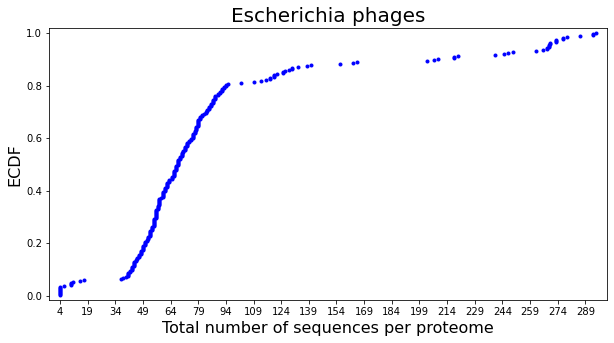

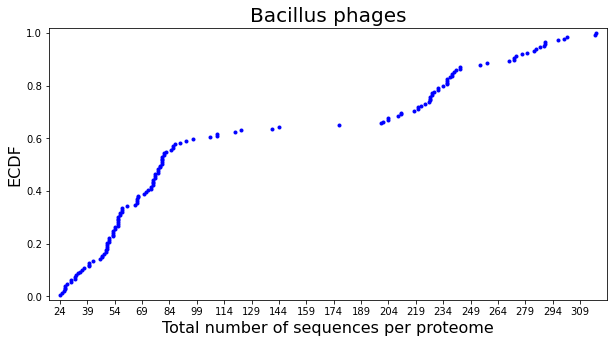

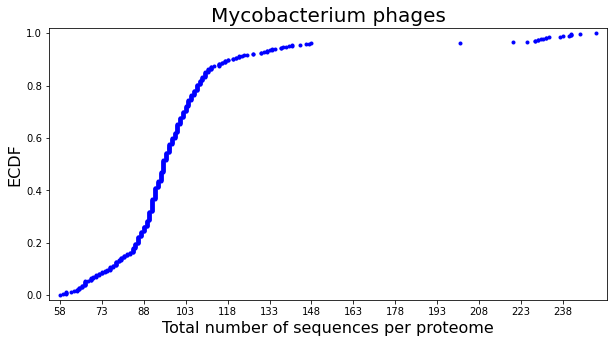

In [77]:
for key in total_seq_in_proteomes_per_group.keys():
    x_set, y_set = ecdf(total_seq_in_proteomes_per_group[key])
    make_plot(x_set, y_set, 15.0, 'Total number of sequences per proteome', key.capitalize() + ' phages')

## 6.2. Reduce sequence redundancy


Basing on analysis performed in previous step, **we will discard phages' proteomes which have below 40 sequences**.

---

From the proteomes that fulfill abovementioned criteria, from each phages' group, we will select all sequences of minimum 150 aa length and use it as input for cd-hit. cd-hit is a software tool which clusters protein sequences based on their identity. This will allow us later to search for lysine desert regions in the clustered version of "one big proteome" for each group.


### Prepare input for cd-hit

Concatenate all sequences minimum 150 aa long from selected phages proteomes (as before; proteomes with over 40 sequences are selected) into one fasta file, separately for each group. Save them to `data` directory as `tmp_escherichia_seq_for_cd-hit.fasta`, `tmp_bacillus_seq_for_cd-hit.fasta` and `tmp_mycobacterium_seq_for_cd-hit.fasta`.


In [68]:
for group in ['bacillus', 'escherichia', 'mycobacterium']:
    out = open('data/tmp_{}_seq_for_cd-hit.fasta'.format(group), 'w')
    for proteome in os.listdir('data/Phages_proteomes/{}'.format(group)):
        if proteome == '.DS_Store': continue
        f = gzip.open('data/Phages_proteomes/{}/{}'.format(group, proteome), "rt")
        fasta_parsed = list(SeqIO.parse(f, 'fasta'))
        
        if len(fasta_parsed) < 40: continue
        
        for seq in fasta_parsed:
            if len(seq.seq)>= 150:
                out.write('>{}\n'.format(seq.id))
                out.write('{}\n'.format(seq.seq))
                
    out.close()

###  Run cd-hit

Submit newly created fasta files to [cd-hit webserver](http://weizhong-lab.ucsd.edu/cdhit-web-server/cgi-bin/index.cgi?cmd=cd-hit), run with default parameters (sequence identity cut-off = 0.9, use global sequence identity: Yes, sequence is clustered to the best cluster that meet the threshold: Yes,  length of sequence to skip = 10). 

When the calculations finish, download all results at once (use option Download all files from the left panel). 

Change name of each downloaded archive to `escherichia`, `bacillus` or `mycobacterium`, depending on the input sequences. Untar it, rename file ending with fas.1 to `clustered_proteome.fasta`, gzip each of the files in the directory separately, e.g. in bacillus directory do in terminal: ```for i in `ls`; do gzip -9 $i; done```

Create directory `data/Phages_proteomes/after_cd-hit` and save there preprocessed as described above  cd-hit results' directories.


Delete unnecessary files

In [ ]:
%%bash

rm data/tmp_escherichia_seq_for_cd-hit.fasta
rm data/tmp_bacillus_seq_for_cd-hit.fasta
rm data/tmp_mycobacterium_seq_for_cd-hit.fasta

## 6.3. Prepare summary tables about selected proteomes used in analysis

Prepare Tables `Table_reference_escherichia_phages_proteomes_summary.tsv`, `Table_reference_bacillus_phages_proteomes_summary.tsv`, and `Table_reference_mycobacterium_phages_proteomes_summary.tsv` summarizing the proteomes selected for analysis (not outliers and with over 40 sequences).

#### Indexing

Supplementary tables are indexed by taxon name.

#### Columns description

Supplementary table contains the following information:


| Column  | Description  |
|:--|:--|
| **UniProt proteome ID**  | Proteome ID from the UniProt database|
| **NCBI taxon ID**  | Taxon ID from the NCBI |
| **Total sequences in proteome**  | Number of all sequences in proteome |


In [7]:
for group in ['escherichia', 'bacillus', 'mycobacterium']:
    sum_dict = {}
    for proteome in os.listdir('data/Phages_proteomes/{}'.format(group)):
        
        if proteome == '.DS_Store': continue
        
        f = gzip.open('data/Phages_proteomes/{}/{}'.format(group, proteome), "rt")
        seq_no = 0
        for seq in SeqIO.parse(f, "fasta"):
            seq_no += 1
                
        if seq_no < 40: continue
        uniprot = proteome.split('_')[0]
        taxon = proteome.split('_')[1].split('.')[0]
        try:
            taxon_ncbi = ncbi.get_taxid_translator([taxon])[int(taxon)]
        except KeyError:
            taxon_ncbi = str(taxon)
        
        sum_dict[taxon_ncbi] = [uniprot, taxon, seq_no]
            
        f.close()
            
    columns = ['UniProt proteome ID',  'NCBI taxon ID', 'Total sequences in proteome']

    df_summary = pd.DataFrame.from_dict(sum_dict, orient='index', columns = columns)                      
    df_summary.index.name = 'Taxon'
    df_summary.to_csv(f'results/supplementary/Table_{group}_phages_proteomes_summary.tsv', sep='\t')   

## 6.4. Prepare summary table about panproteomes generated based on selected proteomes

Prepare Table **Table_phages_proteomes_summary.tsv** summarizing panproteomes' properties for selected phages groups.


### Indexing

Supplementary tables are indexed by phages' group.

### Columns description

Supplementary table contains the following information:

| Column  | Description  |
|:--|:--|
| **Proteomes number**  | Number of all proteomes |
| **Filtered proteomes number**  |  Number of proteomes which have less than 40 sequences (default threshold)|
| **Total sequence number in filtered proteomes**  |  Total number of sequences in filtered proteomes |
| **Fraction of sequences from filtered proteomes used for cd-hit**  |  Fraction of sequences of min. 150 aa length (default threshold) among all sequences in filtered proteomes |
| **Total number of sequences in panproteome** | Total number of sequences after clustering|
| **Median sequence length in panproteome** | Median sequence length after clustering|

In [74]:
phages_filtered_summary_dict = {}

for group in ['bacillus', 'escherichia', 'mycobacterium']:
    proteomes_no = 0
    filtered_proteomes_no = 0
    filtered_prot_seq_no = 0
    filtered_prot_seq_over_150_no = 0
    
    for proteome in os.listdir('data/Phages_proteomes/{}'.format(group)):
        if proteome == '.DS_Store': continue
            
        proteomes_no += 1
        f1 = gzip.open('data/Phages_proteomes/{}/{}'.format(group, proteome), "rt")
        total_seq_no = 0 # no of all seq in proteome
        over_150_seq_no = 0
        
        for seq in SeqIO.parse(f1, "fasta"):
            total_seq_no += 1
            if len(seq.seq) >= 150: over_150_seq_no +=1 
    
        f1.close()
        if total_seq_no >= 40:
            filtered_proteomes_no += 1
            filtered_prot_seq_no += total_seq_no 
            filtered_prot_seq_over_150_no += over_150_seq_no
    
    f2 = gzip.open('data/Phages_proteomes/after_cd-hit/{}/clustered_proteome.fasta.gz'.format(group), "rt")
    cdhit_seq_no = 0
    cdhit_seq_len = []
    for seq in SeqIO.parse(f2, "fasta"):
        cdhit_seq_no += 1
        cdhit_seq_len.append(len(seq.seq))
        
    phages_filtered_summary_dict[group.capitalize()] = [proteomes_no, filtered_proteomes_no,
                                               filtered_prot_seq_no, 
                                               round(100 * filtered_prot_seq_over_150_no/filtered_prot_seq_no, 2),
                                               cdhit_seq_no, statistics.median(cdhit_seq_len)
                                                       ]
columns = ['Proteomes number', 
           'Filtered proteomes number', 'Total sequence number in filtered proteomes',
           'Fraction of sequences from filtered proteomes used for cd-hit', 
           'Total number of sequences in panproteome', 'Median sequence length in panproteome']

df_summary_phages = pd.DataFrame.from_dict(phages_filtered_summary_dict, orient='index', columns = columns)                      
df_summary_phages.index.name = 'Phages group'
display(df_summary_phages)
df_summary_phages.to_csv('results/supplementary/Table_phages_proteomes_summary.tsv', sep='\t')       

,Proteomes number,Filtered proteomes number,Total sequence number in filtered proteomes,Percentage of sequences of min. 150 aa length among,Total number of sequences in panproteome,Median sequence length in panproteome
Phages group,,,,,,
Bacillus,149,133,18659,40.33,5158,256.0
Escherichia,263,245,22931,44.41,5316,260.5
Mycobacterium,527,527,53012,36.93,7332,271.0


# 7. Download table with information about pupylated proteins in Bacteria

In [ ]:
%%bash
wget https://cwtung.kmu.edu.tw/pupdb/pupdb_export.tab -P data